# Modeling par classification

Objectif : entraîner et comparer des modèles de classification sur `data/processed/train.csv` et `test.csv`, avec encodage One-Hot et une priorité métier sur le rappel de la classe "fail" pour ne pas rater d'élèves à risque.

In [19]:
# Imports
import pandas as pd
import numpy as np
from pathlib import Path
import joblib
from collections import OrderedDict
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, recall_score, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import LinearSVC
from sklearn.base import clone
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
RANDOM_STATE = 42  # graine unique pour rendre les runs reproductibles
CV_SPLITS = 5      # validation croisée stratifiée pour limiter la variance sur petit jeu (640 obs)

In [20]:
# Chargement des jeux train/test prétraités
train_path = Path('..') / 'data' / 'processed' / 'train.csv'
test_path = Path('..') / 'data' / 'processed' / 'test.csv'

# On sécurise la présence des fichiers attendus
for p in [train_path, test_path]:
    assert p.exists(), f"Fichier manquant : {p}"

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

# La première colonne est un index sauvegardé par pandas, on la drop
to_drop = [col for col in train_df.columns if col.startswith('Unnamed') or col == '']
train_df = train_df.drop(columns=to_drop)
test_df = test_df.drop(columns=to_drop)

train_df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math passed,language passed,exam passed
0,0,5,4,0,1,1,1,1
1,1,3,0,0,1,0,1,1
2,0,4,2,1,0,1,1,1
3,0,0,2,0,0,1,1,1
4,1,4,2,1,1,1,1,1


Nous avons essayer plusieurs modèles de classification en variant également la target pour voir l'impact sur les performances. En effet, nous avons pensé que les models auraient plus de facilité à prédire si un élève allait réussir ou échouer par matière (tâche 1 et 2) plutôt que globalement (tâche 3).

In [21]:
# Séparation features / cible
target_col = ["language passed", "math passed","exam passed"]

# Colonnes socio-démo communes
base_cols = [
    "gender",
    "race/ethnicity",
    "parental level of education",
    "lunch",
    "test preparation course",
]

# Définition des jeux de features/target pour chaque tâche
tasks = {
    "language": {
        "target": "language passed",
        "features": base_cols 
    },
    "math": {
        "target": "math passed",
        "features": base_cols,
    },
    "exam": {
        "target": "exam passed",
        "features": base_cols,
    },
}

In [31]:
# Préparation des jeux train/test par tâche (sans encodage ici)

data_splits = OrderedDict()
for task_name, spec in tasks.items():
    feat_cols = spec["features"]
    target = spec["target"]

    X_train = train_df[feat_cols]
    y_train = train_df[target]
    X_test_holdout = test_df[feat_cols]
    y_test_holdout = test_df[target]

    data_splits[task_name] = {
        "X_train": X_train,
        "y_train": y_train,
        "X_test": X_test_holdout,
        "y_test": y_test_holdout,
    }

## Choix des modèles, encodage et métriques
- **Encodage** : OneHotEncoder sur toutes les features catégorielles pour éviter d’interpréter des codes entiers comme ordinals (critique pour LogisticRegression et SVM).
- **Validation** : Stratified K-Fold (CV=5) pour réduire la variance sur un petit jeu (~640 obs).
- **Objectif métier** : Nous avons fait le choix de maximiser le **Recall de la classe "fail" (pos_label=0)** afin de ne pas rater d’élèves à risque, quitte à accepter plus de faux positifs.
- **Modèles conservés (simples/robustes)** : LogisticRegression, RandomForest, GradientBoosting, XGB, LGBM, Linear SVM calibré (CalibratedClassifierCV + LinearSVC) — pas de deep learning vu la taille du jeu.
- **Métriques suivies** :
  - **Recall_fail** (prioritaire alerte).
  - **F1** (équilibre précision/rappel sur la classe "pass").
  - **Accuracy** (repère global, sensible au déséquilibre).
  - **ROC AUC** (séparation probabiliste quand `predict_proba`/`decision_function` existe).
- Le meilleur modèle par tâche est choisi sur **Recall_fail (validation croisée)**.

In [ ]:
# Prétraitement One-Hot + modèles + évaluation CV (priorité au recall sur "fail")

# Encodage catégoriel (One-Hot) pour éviter toute interprétation ordinale des codes
categorical_cols = base_cols
preprocessor = ColumnTransformer(
    [
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
    ],
    remainder="drop",
)

# Scorers : rappel de la classe 0 (fail) prioritaire
recall_fail_scorer = make_scorer(recall_score, pos_label=0)
scoring = {
    "accuracy": "accuracy",
    "f1": "f1",
    "roc_auc": "roc_auc",
    "recall_fail": recall_fail_scorer,
}

cv = StratifiedKFold(n_splits=CV_SPLITS, shuffle=True, random_state=RANDOM_STATE)


def make_models_for_task(y_train):
    # Pondération pour renforcer la classe fail (0)
    n_fail = (y_train == 0).sum()
    n_pass = (y_train == 1).sum()
    # éviter division par zéro
    n_fail = max(n_fail, 1)
    n_pass = max(n_pass, 1)
    # poids appliqué à la classe 0 dans LGBM ; pour XGB, scale_pos_weight s'applique à la classe 1, on inverse donc le ratio
    fail_weight = n_pass / n_fail
    scale_pos_weight = n_fail / n_pass  # inverse pour atténuer la classe 1 (pass) si elle domine

    return {
        "log_reg": Pipeline([
            ("prep", preprocessor),
            ("clf", LogisticRegression(max_iter=1000, n_jobs=-1, class_weight="balanced", solver="lbfgs")),
        ]),
        "rf": Pipeline([
            ("prep", preprocessor),
            ("clf", RandomForestClassifier(n_estimators=400, max_depth=None, random_state=RANDOM_STATE, n_jobs=-1, class_weight="balanced")),
        ]),
        "gboost": Pipeline([
            ("prep", preprocessor),
            ("clf", GradientBoostingClassifier(random_state=RANDOM_STATE)),
        ]),
        "xgb": Pipeline([
            ("prep", preprocessor),
            ("clf", XGBClassifier(
                n_estimators=400,
                max_depth=4,
                learning_rate=0.05,
                subsample=0.8,
                colsample_bytree=0.8,
                eval_metric="logloss",
                random_state=RANDOM_STATE,
                n_jobs=-1,
                scale_pos_weight=scale_pos_weight,
            )),
        ]),
        "lgbm": Pipeline([
            ("prep", preprocessor),
            ("clf", LGBMClassifier(
                n_estimators=400,
                max_depth=-1,
                num_leaves=31,
                learning_rate=0.05,
                subsample=0.9,
                colsample_bytree=0.9,
                random_state=RANDOM_STATE,
                class_weight={0: fail_weight, 1: 1.0},
            )),
        ]),
        "linear_svm": Pipeline([
            ("prep", preprocessor),
            ("clf", CalibratedClassifierCV(
                estimator=LinearSVC(class_weight="balanced"),
                cv=3,
                n_jobs=-1,
            )),
        ]),
    }


def cv_eval(model, X, y):
    cv_res = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=scoring,
        n_jobs=-1,
        return_train_score=False,
    )
    return {
        "accuracy": np.mean(cv_res["test_accuracy"]),
        "f1": np.mean(cv_res["test_f1"]),
        "roc_auc": np.mean(cv_res["test_roc_auc"]),
        "recall_fail": np.mean(cv_res["test_recall_fail"]),
    }

# Évalue chaque modèle pour chaque tâche via CV
results = {}
rows = []
models_by_task = {}
for task_name, split in data_splits.items():
    models = make_models_for_task(split["y_train"])
    models_by_task[task_name] = models
    results[task_name] = {}
    for name, model in models.items():
        res = cv_eval(model, split["X_train"], split["y_train"])
        results[task_name][name] = res
        rows.append(
            {
                "target_task": task_name,
                "model": name,
                "accuracy": res["accuracy"],
                "f1": res["f1"],
                "roc_auc": res["roc_auc"],
                "recall_fail": res["recall_fail"],
            }
        )

df_res = pd.DataFrame(rows).sort_values(["target_task", "recall_fail"], ascending=[True, False])
df_res

,target_task,model,accuracy,f1,roc_auc,recall_fail
12,exam,log_reg,0.67250,0.749644,0.739614,0.647475
15,exam,xgb,0.64875,0.735151,0.676067,0.571818
16,exam,lgbm,0.63750,0.729645,0.658446,0.527273
13,exam,rf,0.65125,0.751395,0.645981,0.442323
14,exam,gboost,0.72250,0.821947,0.687385,0.290606
17,exam,linear_svm,0.74375,0.839707,0.738368,0.259495
0,language,log_reg,0.70000,0.779990,0.755340,0.634662
3,language,xgb,0.67375,0.759311,0.713811,0.601772
4,language,lgbm,0.65250,0.740367,0.693787,0.592691
1,language,rf,0.66250,0.756828,0.671325,0.516611


In [24]:
# Sélection du meilleur modèle sur la validation (Recall_fail) pour chaque tâche
best_by_task = {}
for task_name, model_res in results.items():
    best_name = max(model_res, key=lambda name: model_res[name]["recall_fail"])
    best_by_task[task_name] = {
        "model_name": best_name,
        "cv_accuracy": model_res[best_name]["accuracy"],
        "cv_f1": model_res[best_name]["f1"],
        "cv_roc_auc": model_res[best_name]["roc_auc"],
        "cv_recall_fail": model_res[best_name]["recall_fail"],
    }

best_summary = pd.DataFrame(
    [
        {
            "target_task": task_name,
            "best_model": info["model_name"],
            "cv_accuracy": info["cv_accuracy"],
            "cv_f1": info["cv_f1"],
            "cv_roc_auc": info["cv_roc_auc"],
            "cv_recall_fail": info["cv_recall_fail"],
        }
        for task_name, info in best_by_task.items()
    ]
).sort_values("target_task")

print("Scores validation (triés par Recall_fail par tâche):")
display(df_res)
print("\nMeilleurs modèles par tâche (sur Recall_fail):")
display(best_summary)

Scores validation (triés par Recall_fail par tâche):


,target_task,model,accuracy,f1,roc_auc,recall_fail
12,exam,log_reg,0.67250,0.749644,0.739614,0.647475
15,exam,xgb,0.64875,0.735151,0.676067,0.571818
16,exam,lgbm,0.63750,0.729645,0.658446,0.527273
13,exam,rf,0.65125,0.751395,0.645981,0.442323
14,exam,gboost,0.72250,0.821947,0.687385,0.290606
17,exam,linear_svm,0.74375,0.839707,0.738368,0.259495
0,language,log_reg,0.70000,0.779990,0.755340,0.634662
3,language,xgb,0.67375,0.759311,0.713811,0.601772
4,language,lgbm,0.65250,0.740367,0.693787,0.592691
1,language,rf,0.66250,0.756828,0.671325,0.516611



Meilleurs modèles par tâche (sur Recall_fail):


,target_task,best_model,cv_accuracy,cv_f1,cv_roc_auc,cv_recall_fail
2,exam,log_reg,0.6725,0.749644,0.739614,0.647475
0,language,log_reg,0.7000,0.779990,0.755340,0.634662
1,math,log_reg,0.6450,0.710967,0.705670,0.639840


In [ ]:
# Sauvegarde des trois meilleurs modèles (Recall_fail) pour la tâche "exam"
exam_top3 = (
    df_res[df_res["target_task"] == "exam"]
    .sort_values("recall_fail", ascending=False)
    .head(3)
)

models_dir = Path("..") / "models" / "classification"
models_dir.mkdir(parents=True, exist_ok=True)

saved_models = []
for _, row in exam_top3.iterrows():
    model_name = row["model"]
    model_proto = models_by_task["exam"][model_name]
    fitted_model = clone(model_proto)
    fitted_model.fit(data_splits["exam"]["X_train"], data_splits["exam"]["y_train"])
    out_path = models_dir / f"exam_{model_name}.joblib"
    joblib.dump(fitted_model, out_path)
    saved_models.append({"model": model_name, "val_recall_fail": row["recall_fail"], "path": out_path})

print("Modèles exam sauvegardés (top 3 recall_fail validation):")
for item in saved_models:
    print(f"- {item['model']} (val_recall_fail={item['val_recall_fail']:.3f}) -> {item['path']}")

[LightGBM] [Info] Number of positive: 576, number of negative: 224
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

In [26]:
# Évaluation sur le jeu de test tenu à part pour le meilleur modèle de chaque tâche (choisi sur Recall_fail)
test_results = []
test_outputs = {}

for task_name, info in best_by_task.items():
    split = data_splits[task_name]
    model_proto = models_by_task[task_name][info["model_name"]]
    model = clone(model_proto)
    model.fit(split["X_train"], split["y_train"])

    test_preds = model.predict(split["X_test"])
    if hasattr(model, "predict_proba"):
        test_proba = model.predict_proba(split["X_test"])[:, 1]
    elif hasattr(model, "decision_function"):
        test_proba = model.decision_function(split["X_test"])
    else:
        test_proba = None

    metrics = {
        "target_task": task_name,
        "model": info["model_name"],
        "accuracy": accuracy_score(split["y_test"], test_preds),
        "f1": f1_score(split["y_test"], test_preds),
        "recall_fail": recall_score(split["y_test"], test_preds, pos_label=0),
        "roc_auc": roc_auc_score(split["y_test"], test_proba) if test_proba is not None else np.nan,
    }
    test_results.append(metrics)
    test_outputs[task_name] = {"y_true": split["y_test"], "preds": test_preds, "proba": test_proba}

    # Rapport détaillé
    print(f"Rapport de classification ({task_name}):")
    print(classification_report(split["y_test"], test_preds, target_names=["fail", "pass"]))

print("\nScores sur test (meilleur modèle par tâche):")
test_results_df = pd.DataFrame(test_results).sort_values("target_task")
display(test_results_df)

Rapport de classification (language):
              precision    recall  f1-score   support

        fail       0.41      0.73      0.53        52
        pass       0.87      0.64      0.73       148

    accuracy                           0.66       200
   macro avg       0.64      0.68      0.63       200
weighted avg       0.75      0.66      0.68       200

Rapport de classification (math):
              precision    recall  f1-score   support

        fail       0.48      0.71      0.57        62
        pass       0.83      0.65      0.73       138

    accuracy                           0.67       200
   macro avg       0.66      0.68      0.65       200
weighted avg       0.72      0.67      0.68       200

Rapport de classification (exam):
              precision    recall  f1-score   support

        fail       0.37      0.65      0.47        55
        pass       0.81      0.57      0.67       145

    accuracy                           0.59       200
   macro avg       0.5

,target_task,model,accuracy,f1,recall_fail,roc_auc
2,exam,log_reg,0.595,0.672065,0.654545,0.682821
0,language,log_reg,0.660,0.734375,0.730769,0.727326
1,math,log_reg,0.670,0.731707,0.709677,0.723235


## Comment lire les résultats
- **df_res (CV)** : moyennes des scores sur 5 folds stratifiés pour chaque modèle/cible. La colonne clé est **recall_fail** (rappel de la classe échec).
- **best_summary** : meilleur modèle par cible selon **recall_fail** (priorité alerte).
- **Sauvegarde** : pour `exam`, on stocke les 3 meilleurs modèles (recall_fail) dans `models/` pour réutilisation.
- **Rapports de classification (test)** : précision / rappel / F1 par classe sur le jeu de test tenu à part; surveiller le rappel "fail" pour éviter les faux négatifs.
- **Métriques test (table)** : accuracy / F1 / ROC AUC / recall_fail sur le meilleur modèle de chaque cible. On accepte plus de faux positifs pour maximiser recall_fail.
- **Visualisations** :
  - Barres: comparaison des métriques CV par modèle et par cible.
  - Matrices de confusion: localisation des confusions sur le test.
  - Courbes ROC: évalue la qualité probabiliste quand `predict_proba` ou `decision_function` est dispo.
- **Taille des données (640 obs)** : rester sur modèles simples/robustes + CV stratifiée plutôt que deep learning.

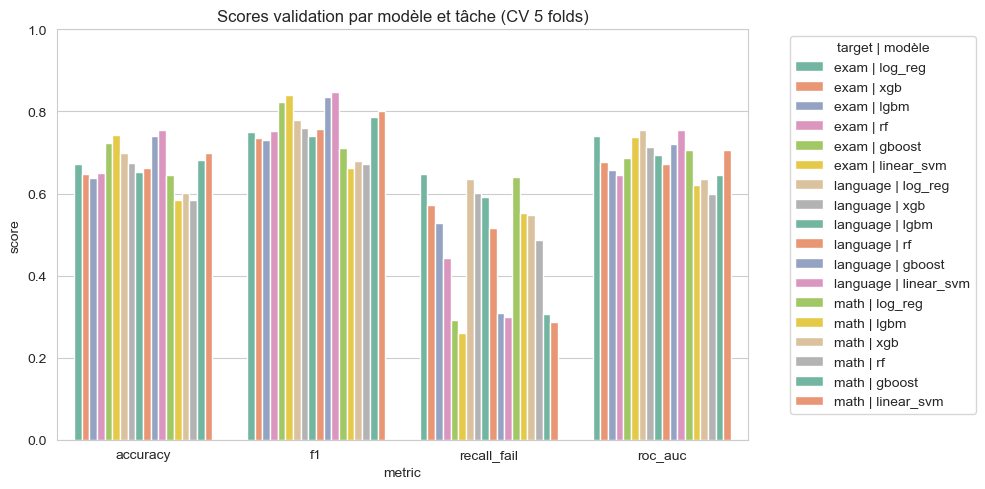

In [27]:
# Visualisation des métriques validation (accuracy / f1 / recall_fail / roc_auc)
plot_df = df_res.melt(id_vars=["target_task", "model"], value_vars=["accuracy", "f1", "recall_fail", "roc_auc"], var_name="metric", value_name="score")
plot_df["label"] = plot_df["target_task"].astype(str) + " | " + plot_df["model"]

plt.figure(figsize=(10, 5))
sns.barplot(data=plot_df, x="metric", y="score", hue="label", palette="Set2")
plt.title("Scores validation par modèle et tâche (CV 5 folds)")
plt.ylim(0, 1)
plt.legend(title="target | modèle", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

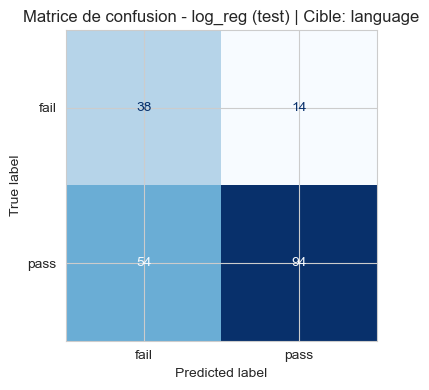

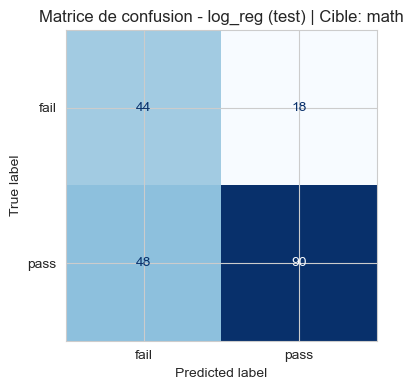

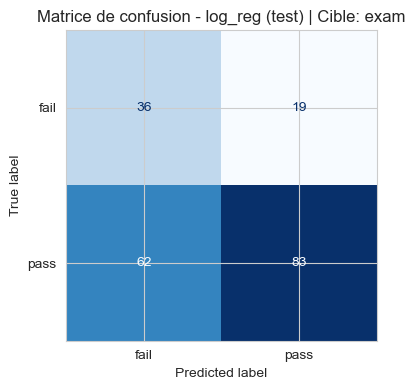

In [28]:
# Matrice de confusion sur le test pour le meilleur modèle de chaque tâche
from sklearn.metrics import ConfusionMatrixDisplay

for task_name, out in test_outputs.items():
    fig, ax = plt.subplots(figsize=(4, 4))
    ConfusionMatrixDisplay.from_predictions(
        out["y_true"],
        out["preds"],
        display_labels=["fail", "pass"],
        cmap="Blues",
        colorbar=False,
        ax=ax,
    )
    ax.set_title(f"Matrice de confusion - {best_by_task[task_name]['model_name']} (test) | Cible: {task_name}")
    plt.tight_layout()
    plt.show()

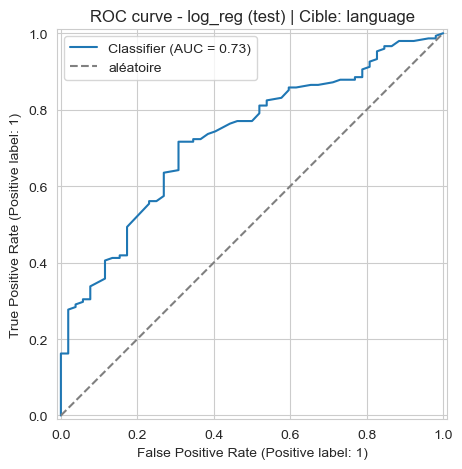

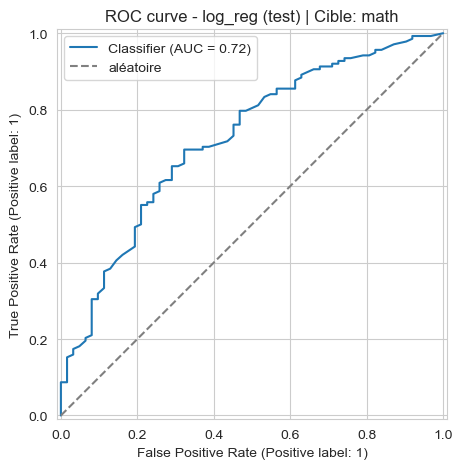

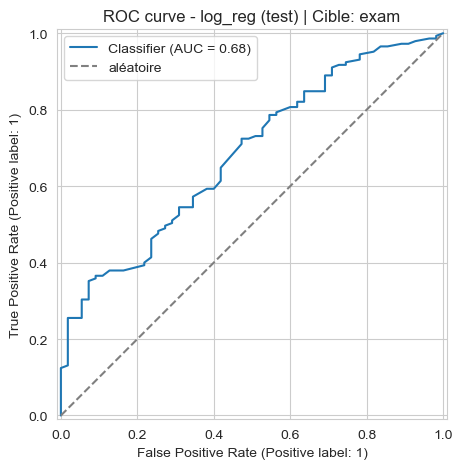

In [29]:
# Courbe ROC sur le test (si proba dispo)
from sklearn.metrics import RocCurveDisplay

for task_name, out in test_outputs.items():
    if out["proba"] is not None:
        RocCurveDisplay.from_predictions(out["y_true"], out["proba"])
        plt.title(f"ROC curve - {best_by_task[task_name]['model_name']} (test) | Cible: {task_name}")
        plt.plot([0, 1], [0, 1], linestyle="--", color="grey", label="aléatoire")
        plt.legend()
        plt.tight_layout()
        plt.show()
    else:
        # Certains modèles calibrés n'exposent pas predict_proba
        print(f"Pas de predict_proba disponible pour {best_by_task[task_name]['model_name']} ({task_name}).")

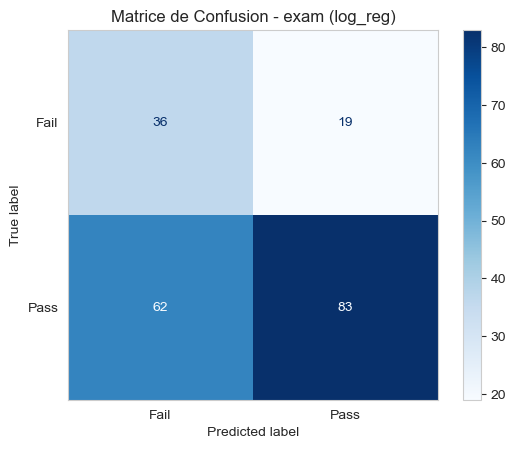

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

task = "exam"
best_model_name = best_by_task[task]["model_name"]
y_true = test_outputs[task]["y_true"]
y_pred = test_outputs[task]["preds"]

ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=["Fail", "Pass"], cmap="Blues")
plt.title(f"Matrice de Confusion - {task} ({best_model_name})")
plt.grid(False)
plt.show()